In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
model = 'random_waypoint'
method = 'mean'

df_eval = pd.concat([
    pd.read_csv(f'evaluate/evaluate_{model}_{i}.csv')
    for i in range(30, 40)
])

In [14]:
df_eval.columns

Index(['velocity', 'towers', 'users', 'accuracy', 'accuracy_std', 'error',
       'error_std', 'recover_time', 'map_time', 'execution_time'],
      dtype='object')

In [15]:
len(df_eval)

1440

In [16]:
df_eval = getattr(df_eval.groupby(['velocity', 'towers', 'users']), method)().reset_index()

In [17]:
df_eval.accuracy.describe()

count    144.000000
mean       0.301464
std        0.225442
min        0.078464
25%        0.136931
50%        0.193936
75%        0.390142
max        0.935677
Name: accuracy, dtype: float64

In [18]:
df_eval.velocity.unique()

array(['(0.01, 0.01)', '(0.05, 0.05)', '(0.1, 0.1)'], dtype=object)

In [19]:
def plot_heatmap(vel_restriction, metric='accuracy', ax=None, vmin=None, vmax=None, cbar=True, title='', cmap=None):
    df = df_eval[df_eval.velocity == vel_restriction]

    df = df.sort_values(['towers', 'users'], ascending=[False, True])
    
    n_tower_values = len(df.towers.unique())
    n_users_values = len(df.users.unique())
    
    if vel_restriction == '(0.1, 0.1)':
        y_right_ticks = reversed([0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2])
    elif vel_restriction == '(0.05, 0.05)':
        y_right_ticks = reversed([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
    elif vel_restriction == '(0.01, 0.01)':
        y_right_ticks = reversed([0.04, 0.08, 0.12, 0.16, 0.19, 0.24, 0.28, 0.32])

    sns.heatmap(
        df[metric].as_matrix().reshape((n_tower_values, n_users_values)),
        ax=ax,
        xticklabels=df['users'].unique(),
        vmax=vmax,
        vmin=vmin,
        cbar=cbar,
        cmap=cmap,
        square=True,
        fmt=".2f",
        annot=True,
    )
    
    ax.set(xlabel='# Users', ylabel='Grid resolution / Relative velocity')
    ax.set_yticklabels(
        [
            f'{np.sqrt(t).astype(np.int)}x{np.sqrt(t).astype(np.int)} / {v}'
            for t, v in zip(df['towers'].unique(), y_right_ticks)
        ],
        rotation=0
    )
    
#     ax2 = ax.twin()
#     ax2.set_yticklabels(
#         y_right_ticks,
#         rotation=0
#     )
#     ax.set_title(title, pad=12)

# Accuracy and error analysis

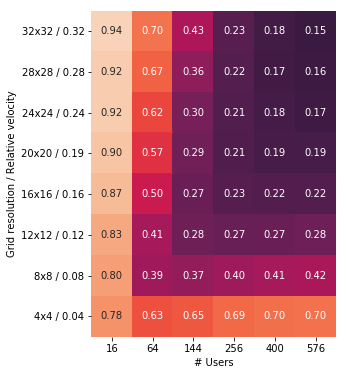

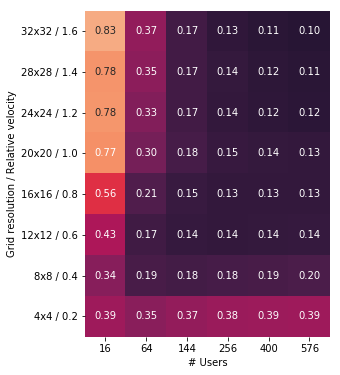

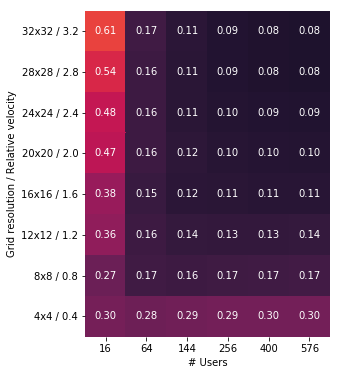

In [20]:
for i, vel in enumerate(df_eval.velocity.unique()):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        title=f'Velocity {vel}',
        metric='accuracy',
        ax=axes,
        vmin=0,
        vmax=1,
        cbar=False)

    plt.savefig(f'./accuracy_{model}_{vel}.png', dpi=300)

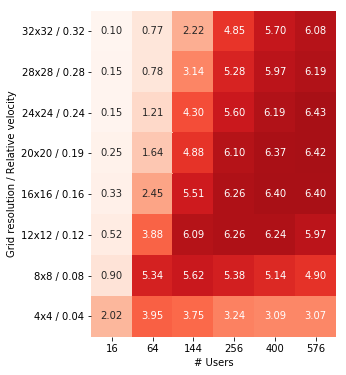

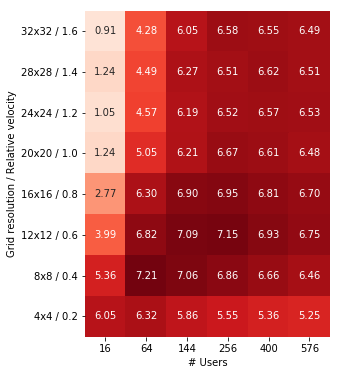

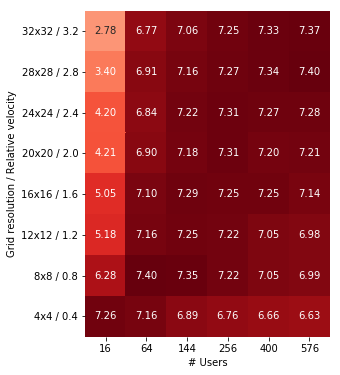

In [21]:
for i, vel in enumerate(df_eval.velocity.unique()):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    plot_heatmap(
        vel_restriction=vel,
        metric='error',
        ax=axes,
        title=f'Velocity {vel}',
        cbar=False,
        cmap='Reds',
        vmin=df_eval.error.min(),
        vmax=df_eval.error.max(),
    )

    plt.savefig(f'./error_{model}_{vel}.png', dpi=300)

# Execution time analysis

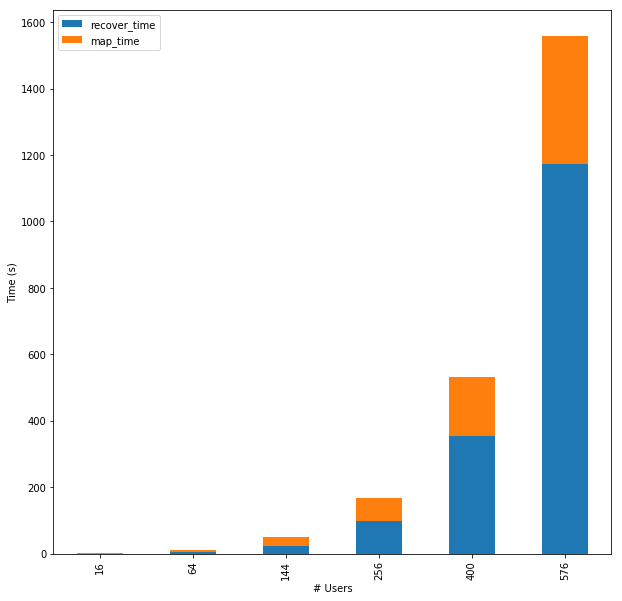

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

df_eval.groupby(['users']).mean()[[
        'recover_time',
        'map_time',
#         'execution_time',
]].plot.bar(ax=ax, stacked=True)

ax.set(xlabel="# Users", ylabel="Time (s)")
plt.savefig(f'./execution_time.png', dpi=300)

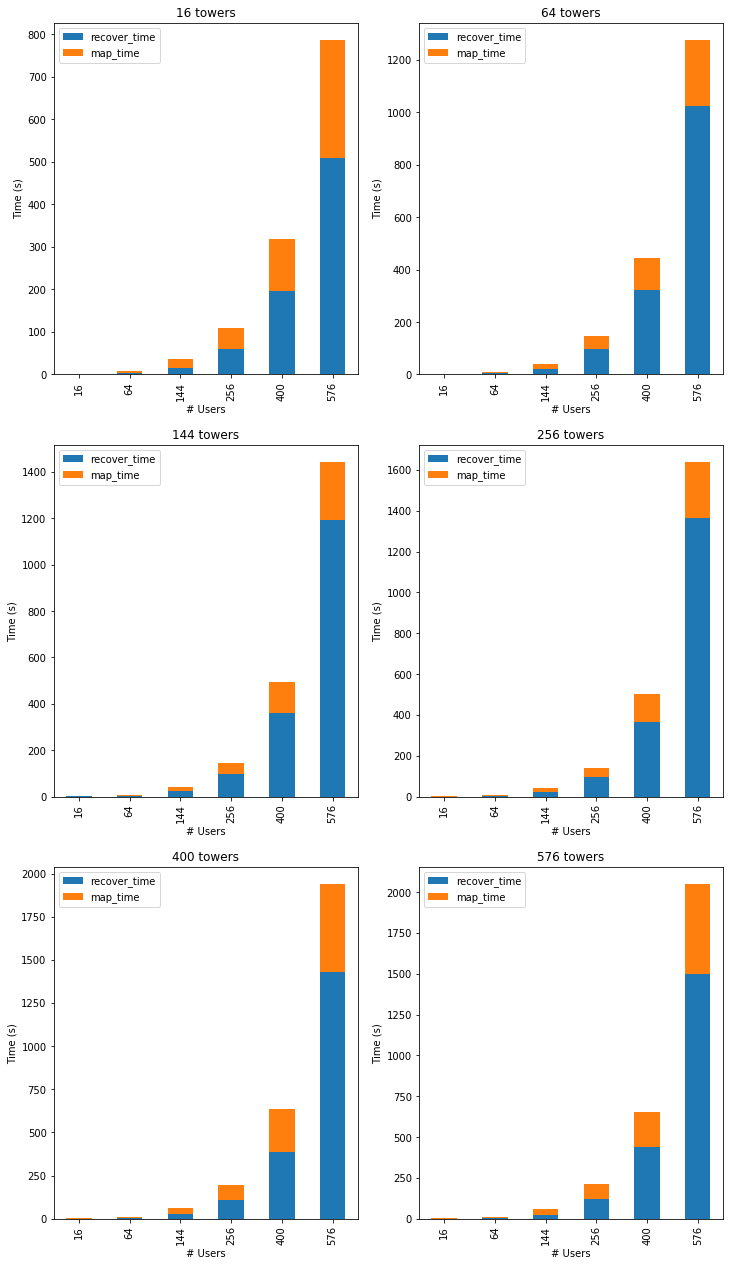

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 22))
axes = axes.flatten()

for ax, t in zip(axes, df_eval.towers.unique()):
    df_eval[df_eval.towers == t].groupby(['users']).mean()[[
        'recover_time',
        'map_time',
#         'execution_time',
    ]].plot.bar(ax=ax, stacked=True)
    ax.set_title(f'{t} towers')
    ax.set(xlabel='# Users', ylabel='Time (s)')

plt.savefig(f'./execution_time_by_towers.png', dpi=300)